In [10]:
# Import modules
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from cenpy import products
from shapely.geometry import Polygon
from numpy.random import RandomState, uniform
from shapely.geometry import Point

# Define product
acs = products.ACS(2019)

In [2]:
# Race data
wayne_white = products.ACS(2019).from_county('Wayne County, MI', level='tract',
                                        variables=['B01001A_001E'])
wayne_black = products.ACS(2019).from_county('Wayne County, MI', level='tract',
                                        variables=['B01001B_001E'])
wayne_native = products.ACS(2019).from_county('Wayne County, MI', level='tract',
                                        variables=['B01001C_001E'])
wayne_asian = products.ACS(2019).from_county('Wayne County, MI', level='tract',
                                        variables=['B01001D_001E'])
wayne_p_islander = products.ACS(2019).from_county('Wayne County, MI', level='tract',
                                        variables=['B01001E_001E'])
wayne_other_race = products.ACS(2019).from_county('Wayne County, MI', level='tract',
                                        variables=['B01001F_001E'])

C:\Users\lucin\anaconda3\envs\final_ML_LR\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\lucin\anaconda3\envs\final_ML_LR\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\lucin\anaconda3\envs\final_ML_LR\lib\site-packages\cenpy\products.py:762: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the

KeyError: 'features'

In [3]:
#Total pop
wayne_pop = products.ACS(2019).from_county('Wayne County, MI', level='tract',
                                        variables=['B01003_001E'])

C:\Users\lucin\anaconda3\envs\final_ML_LR\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\lucin\anaconda3\envs\final_ML_LR\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\lucin\anaconda3\envs\final_ML_LR\lib\site-packages\cenpy\products.py:762: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the

In [18]:
wayne_pop

,GEOID,geometry,B01003_001E,NAME,state,county,tract
0,26163564504,"POLYGON ((-9300168.940 5204972.030, -9300149.6...",7404.0,"Census Tract 5645.04, Wayne County, Michigan",26,163,564504
1,26163563500,"POLYGON ((-9296099.540 5213626.000, -9296071.3...",5976.0,"Census Tract 5635, Wayne County, Michigan",26,163,563500
2,26163587000,"POLYGON ((-9295067.720 5191330.890, -9295014.6...",3889.0,"Census Tract 5870, Wayne County, Michigan",26,163,587000
3,26163567800,"POLYGON ((-9282837.050 5209737.590, -9282821.6...",4909.0,"Census Tract 5678, Wayne County, Michigan",26,163,567800
4,26163565800,"POLYGON ((-9280076.100 5207590.010, -9279649.1...",3550.0,"Census Tract 5658, Wayne County, Michigan",26,163,565800
...,...,...,...,...,...,...,...
606,26163550300,"POLYGON ((-9232215.180 5219603.730, -9232107.3...",3158.0,"Census Tract 5503, Wayne County, Michigan",26,163,550300
607,26163551200,"POLYGON ((-9230920.420 5225940.130, -9230892.4...",4002.0,"Census Tract 5512, Wayne County, Michigan",26,163,551200
608,26163550500,"POLYGON ((-9230513.990 5220925.210, -9230472.8...",3658.0,"Census Tract 5505, Wayne County, Michigan",26,163,550500
609,26163550700,"POLYGON ((-9230048.340 5222182.500, -9229993.4...",5283.0,"Census Tract 5507, Wayne County, Michigan",26,163,550700


In [19]:
def gen_random_points_poly(poly, num_points, seed = None):
    """
    Returns a list of N randomly generated points within a polygon. 
    """
    min_x, min_y, max_x, max_y = poly.bounds
    points = []
    i=0
    while len(points) < num_points:
        s=RandomState(seed+i) if seed else RandomState(seed)
        random_point = Point([s.uniform(min_x, max_x), s.uniform(min_y, max_y)])
        if random_point.within(poly):
            points.append(random_point)
        i+=1
    return points

def gen_points_in_gdf_polys(geometry, values, points_per_value = None, seed = None):
    """
    Take a GeoSeries of Polygons along with a Series of values and returns randomly generated points within
    these polygons. Optionally takes a "points_per_value" integer which indicates the number of points that 
    should be generated for each 1 value.
    """
    if points_per_value:
        new_values = (values/points_per_value).astype(int)
    else:
        new_values = values
    new_values = new_values[new_values>0]
    g = gpd.GeoDataFrame(data = {'vals':new_values}, geometry = geometry)
    
    a = g.apply(lambda row: tuple(gen_random_points_poly(row['geometry'], row['vals'], seed)),1)
    b = gpd.GeoSeries(a.apply(pd.Series).stack(), crs = geometry.crs)
    b.name='geometry'
    return b

def gen_count_dot_density_map(county, pts_per_person = 300, 
                              epsg = 2163, seed=10,
                              dot_transparency=0.4, figsize=(12,12), 
                              ax=None, legend=True):
    """
    Wraps previous functions and generates population dot density maps for a specified county by race
    
    """
    #read in fips to county name relationship file
    county_fips = products.ACS(2019).from_county(county, level='tract',
                                        variables=["B01001A_001E", 'B01001B_001E', 'B01001C_001E', 'B01001D_001E','B01001E_001E', 'B01001F_001E'])
    
    
    #reproject
    #bg_geo = county_fips.to_crs(epsg=4326)
    
    #Calculate county boundaries as the union of block groups 
    union = gpd.GeoSeries(county_fips['geometry'].unary_union)
    
    #if axes object is specified, plot to this axis, otherwise create a new one
    if ax:
        union.plot(color='white', figsize=figsize, ax=ax)
    else:
        ax = union.plot(color='white', figsize=figsize)
   
    #set aspect equal and add title if specified
    ax.set(aspect='equal', xticks=[], yticks=[])
    #set title as county name
    ax.set_title(county, size=15)
    
    #annotate the dot per person ratio
    ax.annotate("1 dot = {} people".format(pts_per_person), 
                xy=(.5, .97), xycoords='axes fraction', horizontalalignment='center',
                fontsize = 12)
        
    #loop each race category and generate points for each within each block group 
    list_of_point_categories=[]
    for field in ["B01001A_001E", 'B01001B_001E', 'B01001C_001E', 'B01001D_001E','B01001E_001E', 'B01001F_001E']:           
        ps=gpd.GeoDataFrame(gen_points_in_gdf_polys(geometry = county_fips['geometry'], values=county_fips[field],
                             points_per_value = pts_per_person, seed=seed))
        ps['field']=field
        list_of_point_categories.append(ps)
    all_points=gpd.GeoDataFrame(pd.concat(list_of_point_categories))
    all_points.plot(ax=ax, markersize=2, alpha=dot_transparency, 
              column='field', categorical=True, legend=legend)

    return ax

C:\Users\lucin\anaconda3\envs\final_ML_LR\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\lucin\anaconda3\envs\final_ML_LR\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\lucin\anaconda3\envs\final_ML_LR\lib\site-packages\cenpy\products.py:762: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the

<AxesSubplot:title={'center':'Wayne County, MI'}>

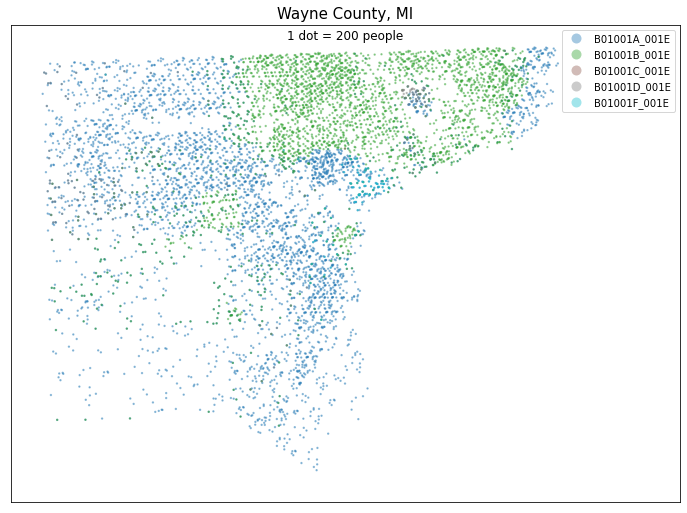

In [20]:
gen_count_dot_density_map('Wayne County, MI', pts_per_person=200)